In [ ]:
% matplotlib inline
import warnings
from collections import Counter, OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import pyarrow as pa   
import pyarrow.parquet as pq
from fastparquet import ParquetFile 
from scipy import sparse
from scipy.spatial.distance import pdist, squareform

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import seaborn as sns

# spacy, textblob and nltk for language processing
from textblob import TextBlob, Word

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.externals import joblib

import json
from time import clock

In [3]:
plt.style.use('fivethirtyeight')

## News article classification

### Read BBC articles

In [4]:
path = Path('..', 'data', 'bbc')
files = path.glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    topic = file.parts[-2]
    article = file.read_text(encoding='latin1').split('\n')
    heading = article[0].strip()
    body = ' '.join([l.strip() for l in article[1:]])
    doc_list.append([topic, heading, body])

In [5]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'body'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
topic      2225 non-null object
heading    2225 non-null object
body       2225 non-null object
dtypes: object(3)
memory usage: 52.2+ KB


### Create stratified train-test split

In [10]:
y = pd.factorize(docs.topic)[0]
X = docs.body
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

### Vectorize text

In [18]:
vectorizer = CountVectorizer()
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

In [19]:
X_train_dtm.shape, X_test_dtm.shape

((1668, 25919), (557, 25919))

### Train Multi-class Naive Bayes model

In [20]:
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

0.9766606822262118


### Evaluate Results

#### Accuracy

In [ ]:
# Calculate accuracy.
metrics.accuracy_score(y_test, y_pred_class)

#### Confusion matrix

In [21]:
pd.DataFrame(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_class))

,0,1,2,3,4
0,98,0,0,2,0
1,0,128,0,0,0
2,0,0,102,2,0
3,2,0,5,121,0
4,0,0,1,1,95


## Twitter Sentiment

- 0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- 1 - the id of the tweet (2087)
- 2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- 3 - the query (lyx). If there is no query, then this value is NO_QUERY.
- 4 - the user that tweeted (robotickilldozr)
- 5 - the text of the tweet (Lyx is cool)

### Read train/test data

In [31]:
names = ['polarity', 'id', 'date', 'query', 'user', 'text']
train = (pd.read_csv('../data/sentiment140/train.csv',
                     low_memory=False,
                     encoding='latin1',
                     header=None,
                     names=names,
                     parse_dates=['date'])
         .drop('query'))

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/dateutil/parser/_parser.py:1204: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [41]:
test = pd.read_csv('../data/sentiment140/test.csv',
                    low_memory=False,
                    encoding='latin1',
                    header=None,
                    names=names,
                    parse_dates=['date'])

### Explore data

In [32]:
train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
polarity    1600000 non-null int64
id          1600000 non-null int64
date        1600000 non-null datetime64[ns]
query       1600000 non-null object
user        1600000 non-null object
text        1600000 non-null object
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 73.2+ MB


In [43]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 6 columns):
polarity    498 non-null int64
id          498 non-null int64
date        498 non-null datetime64[ns]
query       498 non-null object
user        498 non-null object
text        498 non-null object
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 23.4+ KB


In [33]:
train.head()

,polarity,id,date,query,user,text
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [46]:
train.drop_duplicates(subset=['polarity', 'text']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1583691 entries, 0 to 1599999
Data columns (total 6 columns):
polarity    1583691 non-null int64
id          1583691 non-null int64
date        1583691 non-null datetime64[ns]
query       1583691 non-null object
user        1583691 non-null object
text        1583691 non-null object
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 84.6+ MB


In [37]:
train.polarity.value_counts()

4    800000
0    800000
Name: polarity, dtype: int64

In [38]:
print(train.text.str.len().describe())

count    1.600000e+06
mean     7.409011e+01
std      3.644114e+01
min      6.000000e+00
25%      4.400000e+01
50%      6.900000e+01
75%      1.040000e+02
max      3.740000e+02
Name: text, dtype: float64


In [50]:
train.user.value_counts().head(10)

lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
mcraddictal        276
tsarnick           248
what_bugs_u        246
Karen230683        238
DarkPiano          236
Name: user, dtype: int64

### Create text vectorizer

In [39]:
vectorizer = CountVectorizer(min_df=.01, max_df=.8, stop_words='english')
train_dtm = vectorizer.fit_transform(train.text)

In [40]:
train_dtm

<1600000x81 sparse matrix of type '<class 'numpy.int64'>'
	with 2772042 stored elements in Compressed Sparse Row format>

In [51]:
test_dtm = vectorizer.transform(test.text)

In [55]:
test.polarity.value_counts()

4    182
0    177
2    139
Name: polarity, dtype: int64

### Train Naive Bayes Classifier

In [ ]:
nb = MultinomialNB()
nb.fit(X_train_dtm,train.polarity)

y_pred_class = nb.predict(X_test_dtm)

### Evaluate Results

In [ ]:
metrics.accuracy_score(y_test, y_pred_class)

## Yelp Challenge: business reviews dataset

### Parse json and store as parquet files

In [4]:
yelp_dir = Path('..', 'data', 'yelp')
parquet_dir = yelp_dir / 'parquet'
if not parquet_dir.exists():
    parquet_dir.mkdir(exist_ok=True)

In [9]:
# move the review and user files into a new 'json' folder
# we will only use yelp_academic_dataset_{review|user}.json

for file in ['review', 'user']:
    print(file)
    json_file = yelp_dir / 'json' / f'yelp_academic_dataset_{file}.json'
    parquet_file = parquet_dir / f'{file}.parquet'

    data = json_file.read_text(encoding='utf-8')
    json_data = '[' + ','.join([l.strip()
                                for l in data.split('\n') if l.strip()]) + ']\n'
    data = json.loads(json_data)
    df = json_normalize(data)
    if file == 'review':
        df.date = pd.to_datetime(df.date)
        latest = df.date.max()
        df['year'] = df.date.dt.year
        df['month'] = df.date.dt.month
        df = df.drop(['date', 'business_id', 'review_id'], axis=1)
    if file == 'user':
        df.yelping_since = pd.to_datetime(df.yelping_since)
        df = (df.assign(member_yrs=lambda x: (latest - x.yelping_since)
                        .dt.days.div(365).astype(int))
              .drop(['elite', 'friends', 'name', 'yelping_since'], axis=1))
    df.dropna(how='all', axis=1).to_parquet(parquet_file, compression='gzip')
    try:
        pd.read_parquet(parquet_file, engine='pyarrow')
    except Exception as e:
        print(e)
        # at the time of writing, pyarrow had a bug re large text columns
        # https://issues.apache.org/jira/browse/ARROW-3762
        pd.read_parquet(parquet_file, engine='fastparquet')

review
Arrow error: Capacity error: BinaryArray cannot contain more than 2147483646 bytes, have 2147483692
user


In [14]:
user = pd.read_parquet(parquet_dir / 'user.parquet')
user.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1518169 entries, 0 to 1518168
Data columns (total 19 columns):
average_stars         1518169 non-null float64
compliment_cool       1518169 non-null int64
compliment_cute       1518169 non-null int64
compliment_funny      1518169 non-null int64
compliment_hot        1518169 non-null int64
compliment_list       1518169 non-null int64
compliment_more       1518169 non-null int64
compliment_note       1518169 non-null int64
compliment_photos     1518169 non-null int64
compliment_plain      1518169 non-null int64
compliment_profile    1518169 non-null int64
compliment_writer     1518169 non-null int64
cool                  1518169 non-null int64
fans                  1518169 non-null int64
funny                 1518169 non-null int64
review_count          1518169 non-null int64
useful                1518169 non-null int64
user_id               1518169 non-null object
member_yrs            1518169 non-null int64
dtypes: float64(1), int64(17)

In [15]:
user.head()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,compliment_profile,compliment_writer,cool,fans,funny,review_count,useful,user_id,member_yrs
0,2.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,lzlZwIpuSWXEnNS91wxjHw,2
1,5.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,XvLBr-9smbI0m_a7dXtB7w,2
2,4.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,QPT4Ud4H5sJVr68yXhoWFw,1
3,4.05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,i5YitlHZpf0B3R0s_8NVuw,3
4,3.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,s4FoIXE_LSGviTHBe8dmcg,1


In [16]:
review = pd.read_parquet(parquet_dir / 'review.parquet', engine='fastparquet')
review.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5996996 entries, 0 to 5996995
Data columns (total 8 columns):
cool       5996996 non-null int64
funny      5996996 non-null int64
stars      5996996 non-null int64
text       5996996 non-null object
useful     5996996 non-null int64
user_id    5996996 non-null object
year       5996996 non-null int64
month      5996996 non-null int64
dtypes: int64(6), object(2)
memory usage: 411.8+ MB


### Merge review and user files

In [19]:
combined = (review
            .merge(user, on='user_id', how='left', suffixes=['', '_user'])
            .drop('user_id', axis=1))
combined = combined[combined.stars > 0]
combined.info(null_counts=True)
combined.to_parquet(parquet_dir / 'combined.parquet', compression='gzip')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5996996 entries, 0 to 5996995
Data columns (total 25 columns):
cool                  5996996 non-null int64
funny                 5996996 non-null int64
stars                 5996996 non-null int64
text                  5996996 non-null object
useful                5996996 non-null int64
year                  5996996 non-null int64
month                 5996996 non-null int64
average_stars         5996996 non-null float64
compliment_cool       5996996 non-null int64
compliment_cute       5996996 non-null int64
compliment_funny      5996996 non-null int64
compliment_hot        5996996 non-null int64
compliment_list       5996996 non-null int64
compliment_more       5996996 non-null int64
compliment_note       5996996 non-null int64
compliment_photos     5996996 non-null int64
compliment_plain      5996996 non-null int64
compliment_profile    5996996 non-null int64
compliment_writer     5996996 non-null int64
cool_user             5996996

In [6]:
combined = pd.read_parquet(parquet_dir / 'combined.parquet', engine='fastparquet')

In [9]:
combined.to_parquet(parquet_dir / 'combined.parquet', compression='gzip')

### Explore data

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


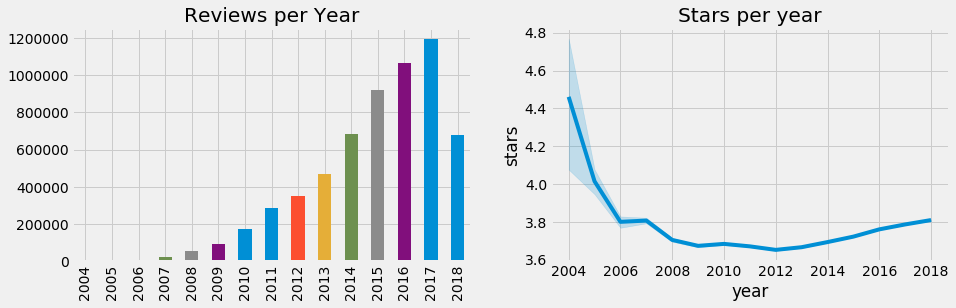

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
combined.year.value_counts().sort_index().plot.bar(title='Reviews per Year', ax=axes[0]);
sns.lineplot(x='year', y='stars', data=combined, ax=axes[1])
axes[1].set_title('Stars per year');

In [40]:
combined.member_yrs.value_counts().sort_index()

0     159440
1     336847
2     607776
3     747215
4     753483
5     789312
6     767460
7     750720
8     484111
9     326262
10    170026
11     78357
12     21801
13      4185
Name: member_yrs, dtype: int64

In [41]:
combined.stars.value_counts(normalize=True).sort_index().mul(100)

1    14.309483
2     8.134291
3    11.225722
4    22.277107
5    44.053397
Name: stars, dtype: float64

### Create train-test split

In [43]:
train = combined[combined.year < 2018]
test = combined[combined.year == 2018]

In [44]:
train.to_parquet(parquet_dir / 'train.parquet', compression='gzip')
test.to_parquet(parquet_dir / 'test.parquet', compression='gzip')

In [40]:
train = pd.read_parquet(parquet_dir / 'train.parquet', engine='fastparquet')
test = pd.read_parquet(parquet_dir / 'test.parquet', engine='fastparquet')

### Create Yelp review document-term matrix

In [45]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=10000)
train_dtm = vectorizer.fit_transform(train.text)
train_dtm

<5319617x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 239481428 stored elements in Compressed Sparse Row format>

In [46]:
sparse.save_npz(parquet_dir / 'train_dtm', train_dtm)

In [31]:
train_dtm = sparse.load_npz(parquet_dir / 'train_dtm.npz')

In [47]:
test_dtm = vectorizer.transform(test.text)
sparse.save_npz(parquet_dir / 'test_dtm', test_dtm)

In [32]:
test_dtm = sparse.load_npz(parquet_dir / 'test_dtm.npz')

### Train Multiclass Naive Bayes

In [48]:
nb = MultinomialNB()
nb.fit(train_dtm,train.stars)
y_pred_class = nb.predict(test_dtm)

### Evaluate results

In [49]:
# Calculate accuracy.
metrics.accuracy_score(test.stars, y_pred_class)

0.6465164206691094

In [50]:
metrics.confusion_matrix(test.stars, y_pred_class)

array([[ 81894,  20469,   3958,   1688,   2108],
       [ 14103,  17228,  10539,   2651,   1634],
       [  6814,  10150,  23281,  13867,   3840],
       [  4256,   3256,  13336,  64966,  25310],
       [ 15812,   2004,   3756,  79891, 250567]])


### Combine non-text features with the document-term matrix

The Vectorizers produce scipy.sparse matrices. To combine the vectorized text data with other features, we need to first convert these to sparse matrices as well; many sklearn algorithm can handle these. Converting the sparse matrix to a dense numpy array risks memory overflow.

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5319617 entries, 0 to 5996992
Data columns (total 25 columns):
cool                  int64
funny                 int64
stars                 int64
text                  object
useful                int64
year                  int64
month                 int64
average_stars         float64
compliment_cool       int64
compliment_cute       int64
compliment_funny      int64
compliment_hot        int64
compliment_list       int64
compliment_more       int64
compliment_note       int64
compliment_photos     int64
compliment_plain      int64
compliment_profile    int64
compliment_writer     int64
cool_user             int64
fans                  int64
funny_user            int64
review_count          int64
useful_user           int64
member_yrs            int64
dtypes: float64(1), int64(23), object(1)
memory usage: 1.0+ GB


#### Train set

In [57]:
# Cast other feature columns to float and convert to a sparse matrix.
train_numeric = sparse.csr_matrix(train.drop(['text', 'stars'], axis=1).astype(float))
train_numeric.shape

(5319617, 23)

In [58]:
# Combine sparse matrices.
train_dtm_numeric = sparse.hstack((train_dtm, train_numeric))
train_dtm_numeric.shape

(5319617, 10023)

In [60]:
sparse.save_npz(parquet_dir / 'train_dtm_numeric', train_dtm_numeric)

#### Repeat for test set

In [59]:
# Repeat for testing set.
test_numeric = sparse.csr_matrix(test.drop(['text', 'stars'], axis=1).astype(float))
test_dtm_numeric = sparse.hstack((test_dtm, test_numeric))
test_dtm_numeric.shape

(677378, 10023)

In [61]:
sparse.save_npz(parquet_dir / 'test_dtm_numeric', test_dtm_numeric)

In [33]:
train_dtm_numeric = sparse.load_npz(parquet_dir / 'train_dtm_numeric.npz')
test_dtm_numeric = sparse.load_npz(parquet_dir / 'test_dtm_numeric.npz')

### Logistic Regression

#### Text features only

In [42]:
logreg = LogisticRegression(C=1e9)
logreg.fit(X=train_dtm, y=train.stars)
y_pred_class = logreg.predict(test_dtm)

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [43]:
joblib.dump(logreg, 'train_dtm.joblib') 

['train_dtm.joblib']

##### Evaluate Results

In [45]:
print(metrics.accuracy_score(test.stars, y_pred_class))

0.7360498864740219


#### Combined Features

In [ ]:
# Use logistic regression with all features.
logreg.fit(train_dtm_numeric, train.stars)
y_pred_class = logreg.predict(test_dtm_numeric)

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [ ]:
joblib.dump(logreg, 'train_dtm_numeric.joblib') 

In [ ]:
print(metrics.accuracy_score(test.stars, y_pred_class))

## Textblob for Sentiment Analysis

In [24]:
sample_review = combined.text.sample(1).iloc[0]
print(sample_review)

Hosted my company Christmas party (38ppl) here this last weekend.  Wonderful evening!  Manager Jeremy Atay was very helpful and accommodating .  Wait staff were great and  food excellent!  They also have a great AV system which we used for our holiday office video.  
Thank you Grape Street for a lovely evening!


In [25]:
# Polarity ranges from -1 (most negative) to 1 (most positive).
TextBlob(sample_review).sentiment.polarity

0.6321428571428571

In [34]:
# Define a function that accepts text and returns the polarity.
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [36]:
sample_reviews = combined[['stars', 'text']].sample(100000)

In [37]:
# Create a new DataFrame column for sentiment (Warning: SLOW!).
sample_reviews['sentiment'] = sample_reviews.text.apply(detect_sentiment)

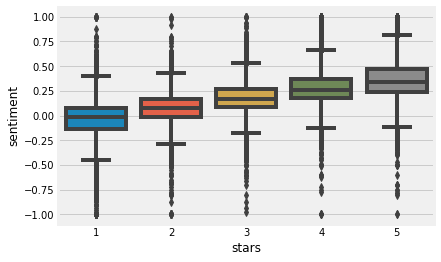

In [38]:
# Box plot of sentiment grouped by stars
sns.boxplot(x='stars', y='sentiment', data=sample_reviews);

In [54]:
# Reviews with most positive sentiment
yelp[yelp.sentiment == 1].text.head()

254    Our server Gary was awesome. Food was amazing....
347    3 syllables for this place. \nA-MAZ-ING!\n\nTh...
420                                    LOVE the food!!!!
459    Love it!!! Wish we still lived in Arizona as C...
679                                     Excellent burger
Name: text, dtype: object

In [55]:
# Reviews with most negative sentiment
yelp[yelp.sentiment == -1].text.head()

773     This was absolutely horrible. I got the suprem...
1517                  Nasty workers and over priced trash
3266    Absolutely awful... these guys have NO idea wh...
4766                                       Very bad food!
5812        I wouldn't send my worst enemy to this place.
Name: text, dtype: object

In [56]:
# Widen the column display.
pd.set_option('max_colwidth', 500)

In [57]:
# Negative sentiment in a 5-star review
yelp[(yelp.stars == 5) & (yelp.sentiment < -0.3)].head(1)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length,sentiment
390,106JT5p8e8Chtd0CZpcARw,2009-08-06,KowGVoP_gygzdSu6Mt3zKQ,5,"RIP AZ Coffee Connection. :( I stopped by two days ago unaware that they had closed. I am severely bummed. This place is irreplaceable! Damn you, Starbucks and McDonalds!",review,jKeaOrPyJ-dI9SNeVqrbww,1,0,0,175,-0.302083


In [58]:
# Positive sentiment in a 1-star review
yelp[(yelp.stars == 1) & (yelp.sentiment > 0.5)].head(1)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length,sentiment
1781,53YGfwmbW73JhFiemNeyzQ,2012-06-22,Gi-4O3EhE175vujbFGDIew,1,If you like the stuck up Scottsdale vibe this is a good place for you. The food isn't impressive. Nice outdoor seating.,review,Hqgx3IdJAAaoQjvrUnbNvw,0,1,2,119,0.766667


In [59]:
# Reset the column display width.
pd.reset_option('max_colwidth')



## Applying Naive Bayes Classification to Spam Filtering

Let's pretend we have an email with three words: "Send money now." We'll use Naive Bayes to classify it as **ham or spam.** ("Ham" just means not spam. It can include emails that look like spam but that you opt into!)

$$P(spam \ | \ \text{send money now}) = \frac {P(\text{send money now} \ | \ spam) \times P(spam)} {P(\text{send money now})}$$

By assuming that the features (the words) are conditionally independent, we can simplify the likelihood function:

$$P(spam \ | \ \text{send money now}) \approx \frac {P(\text{send} \ | \ spam) \times P(\text{money} \ | \ spam) \times P(\text{now} \ | \ spam) \times P(spam)} {P(\text{send money now})}$$

Note that each conditional probability in the numerator is easily calculated directly from the training data!

So, we can calculate all of the values in the numerator by examining a corpus of spam email:

$$P(spam \ | \ \text{send money now}) \approx \frac {0.2 \times 0.1 \times 0.1 \times 0.9} {P(\text{send money now})} = \frac {0.0018} {P(\text{send money now})}$$

We would repeat this process with a corpus of ham email:

$$P(ham \ | \ \text{send money now}) \approx \frac {0.05 \times 0.01 \times 0.1 \times 0.1} {P(\text{send money now})} = \frac {0.000005} {P(\text{send money now})}$$

All we care about is whether spam or ham has the higher probability, and so we predict that the email is spam.

Below is the equation for Bayes.  

$$P(A \ | \ B) = \frac {P(B \ | \ A) \times P(A)} {P(B)}$$

- **$P(A \ | \ B)$** : Probability of `Event A` occurring given `Event B` has occurred.
- **$P(B \ | \ A)$** : Probability of `Event B` occurring given `Event A` has occurred.
- **$P(A)$** : Probability of `Event A` occurring.
- **$P(B)$** : Probability of `Event B` occurring.

In [12]:
# Use default options for CountVectorizer.
vect = CountVectorizer()

# Create document-term matrices.
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

# Use Naive Bayes to predict the star rating.
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))

0.9187866927592955


In [13]:
y_test.value_counts()

5    838
1    184
Name: stars, dtype: int64

In [14]:
# Calculate null accuracy.
y_test_binary = np.where(y_test==5, 1, 0) # five stars become 1, one stars become 0
print('Percent 5 Stars:', y_test_binary.mean())
print('Percent 1 Stars:', 1 - y_test_binary.mean())

Percent 5 Stars: 0.8199608610567515
Percent 1 Stars: 0.18003913894324852


Our model predicted ~92% accuracy, which is an improvement over this baseline 82% accuracy (assuming our model always predicts 5 stars).

Let's look more into how the vectorizer works.

In [15]:
# Notice how the data was transformed into this sparse matrix with 1,022 datapoints and 16,825 features!
#   - Recall that vectorizations of text will be mostly zeros, since only a few unique words are in each document.
#   - For that reason, instead of storing all the zeros we only store non-zero values (inside the 'sparse matrix' data structure!).
#   - We have 3064 Yelp reviews in our training set.
#   - 16,825 unique words were found across all documents.

X_train_dtm

<3064x16825 sparse matrix of type '<class 'numpy.int64'>'
	with 237720 stored elements in Compressed Sparse Row format>

In [18]:
# We will use this function below for simplicity.

# Define a function that accepts a vectorizer and calculates the accuracy.
def tokenize_test(vect):
    X_train_dtm = vect.fit_transform(X_train)
    print(('Features: ', X_train_dtm.shape[1]))
    X_test_dtm = vect.transform(X_test)
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)
    print(('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class)))

In [19]:
# min_df ignores words that occur less than twice ('df' means "document frequency").
vect = CountVectorizer(min_df=2, max_features=10000)
tokenize_test(vect)

('Features: ', 8783)
('Accuracy: ', 0.9246575342465754)


<a id='ngrams'></a>
### N-Grams

N-grams are features which consist of N consecutive words. This is useful because using the bag-of-words model, treating `data scientist` as a single feature has more meaning than having two independent features `data` and `scientist`!

Example:
```
my cat is awesome
Unigrams (1-grams): 'my', 'cat', 'is', 'awesome'
Bigrams (2-grams): 'my cat', 'cat is', 'is awesome'
Trigrams (3-grams): 'my cat is', 'cat is awesome'
4-grams: 'my cat is awesome'
```

- **ngram_range:** tuple (min_n, max_n)
- The lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such that min_n <= n <= max_n will be used.

In [20]:
# Include 1-grams and 2-grams.
vect = CountVectorizer(ngram_range=(1, 2))
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm.shape

(3064, 169847)

We can start to see how supplementing our features with n-grams can lead to more feature columns. When we produce n-grams from a document with $W$ words, we add an additional $(n-W+1)$ features (at most). That said, be careful — when we compute n-grams from an entire corpus, the number of _unique_ n-grams could be vastly higher than the number of _unique_ unigrams! This could cause an undesired feature explosion.

Although we sometimes add important new features that have meaning such as `data scientist`, many of the new features will just be noise. So, particularly if we do not have much data, adding n-grams can actually decrease model performance. This is because if each n-gram is only present once or twice in the training set, we are effectively adding mostly noisy features to the mix.

In [21]:
# Last 50 features
print((vect.get_feature_names()[-50:]))

['zone out', 'zone when', 'zones', 'zones dolls', 'zoning', 'zoning issues', 'zoo', 'zoo and', 'zoo is', 'zoo not', 'zoo the', 'zoo ve', 'zoyo', 'zoyo for', 'zucca', 'zucca appetizer', 'zucchini', 'zucchini and', 'zucchini bread', 'zucchini broccoli', 'zucchini carrots', 'zucchini fries', 'zucchini pieces', 'zucchini strips', 'zucchini veal', 'zucchini very', 'zucchini with', 'zuchinni', 'zuchinni again', 'zuchinni the', 'zumba', 'zumba class', 'zumba or', 'zumba yogalates', 'zupa', 'zupa flavors', 'zuzu', 'zuzu in', 'zuzu is', 'zuzu the', 'zwiebel', 'zwiebel kräuter', 'zzed', 'zzed in', 'éclairs', 'éclairs napoleons', 'école', 'école lenôtre', 'ém', 'ém all']


In [22]:
# Show vectorizer options.
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [23]:
# Remove English stop words.
vect = CountVectorizer(stop_words='english')
tokenize_test(vect)
vect.get_params()

('Features: ', 16528)
('Accuracy: ', 0.9158512720156555)


{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': 'english',
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [24]:
# Set of stop words
print((vect.get_stop_words()))

frozenset({'although', 'fifteen', 'least', 'nobody', 'onto', 'much', 'both', 'seeming', 'here', 'keep', 'upon', 'mill', 'amoungst', 'bill', 'cant', 'due', 'over', 'before', 'con', 'somewhere', 'system', 'it', 'being', 'afterwards', 'except', 'through', 'as', 'only', 'yet', 'empty', 'side', 'each', 'am', 'became', 'couldnt', 'may', 'has', 'whether', 'yourself', 'thick', 'whose', 'or', 'had', 'he', 'in', 'his', 'been', 'noone', 'nor', 'they', 'was', 'beyond', 'toward', 'also', 'three', 'above', 'now', 'what', 'should', 'mine', 'anything', 'beforehand', 'sincere', 'under', 'across', 'of', 'ourselves', 'else', 'my', 'somehow', 'something', 'them', 'rather', 'then', 'together', 'nothing', 'twelve', 'us', 'hereby', 'were', 'is', 'back', 'thin', 'either', 'full', 'very', 'anyway', 'less', 'have', 'which', 'detail', 'front', 'twenty', 'every', 'almost', 'about', 'already', 'sometimes', 'go', 'who', 'will', 'themselves', 'among', 'up', 'cannot', 'fill', 'herself', 'their', 'whereas', 'further',

<a id='cvec_opt'></a>
### Other CountVectorizer Options

- `max_features`: int or None, default=None
- If not None, build a vocabulary that only consider the top `max_features` ordered by term frequency across the corpus. This allows us to keep more common n-grams and remove ones that may appear once. If we include words that only occur once, this can lead to said features being highly associated with a class and cause overfitting.

In [25]:
# Remove English stop words and only keep 100 features.
vect = CountVectorizer(stop_words='english', max_features=100)
tokenize_test(vect)

('Features: ', 100)
('Accuracy: ', 0.8698630136986302)


In [26]:
# All 100 features
print((vect.get_feature_names()))

['amazing', 'area', 'atmosphere', 'awesome', 'bad', 'bar', 'best', 'better', 'big', 'came', 'cheese', 'chicken', 'clean', 'coffee', 'come', 'day', 'definitely', 'delicious', 'did', 'didn', 'dinner', 'don', 'eat', 'excellent', 'experience', 'favorite', 'feel', 'food', 'free', 'fresh', 'friendly', 'friends', 'going', 'good', 'got', 'great', 'happy', 'home', 'hot', 'hour', 'just', 'know', 'like', 'little', 'll', 'location', 'long', 'looking', 'lot', 'love', 'lunch', 'make', 'meal', 'menu', 'minutes', 'need', 'new', 'nice', 'night', 'order', 'ordered', 'people', 'perfect', 'phoenix', 'pizza', 'place', 'pretty', 'prices', 'really', 'recommend', 'restaurant', 'right', 'said', 'salad', 'sandwich', 'sauce', 'say', 'service', 'staff', 'store', 'sure', 'table', 'thing', 'things', 'think', 'time', 'times', 'took', 'town', 'tried', 'try', 've', 'wait', 'want', 'way', 'went', 'wine', 'work', 'worth', 'years']


Just like with all other models, more features does not mean a better model. So, we must tune our feature generator to remove features whose predictive capability is none or very low.

In this case, there is roughly a 1.6% increase in accuracy when we double the n-gram size and increase our max features by 1,000-fold. Note that if we restrict it to only unigrams, then the accuracy increases even more! So, bigrams were very likely adding more noise than signal. 

In the end, by only using 16,000 unigram features we came away with a much smaller, simpler, and easier-to-think-about model which also resulted in higher accuracy.

In [27]:
# Include 1-grams and 2-grams, and limit the number of features.

print('1-grams and 2-grams, up to 100K features:')
vect = CountVectorizer(ngram_range=(1, 2), max_features=100000)
tokenize_test(vect)

print()
print('1-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(1, 1), max_features=100000)
tokenize_test(vect)

1-grams and 2-grams, up to 100K features:
('Features: ', 100000)
('Accuracy: ', 0.8855185909980431)

1-grams only, up to 100K features:
('Features: ', 16825)
('Accuracy: ', 0.9187866927592955)


- `min_df`: Float in range [0.0, 1.0] or int, default=1
- When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts.

In [28]:
# Include 1-grams and 2-grams, and only include terms that appear at least two times.
vect = CountVectorizer(ngram_range=(1, 2), min_df=2)
tokenize_test(vect)

('Features: ', 43957)
('Accuracy: ', 0.9324853228962818)
